<a href="https://colab.research.google.com/github/lianealbarghouthi/projects/blob/main/Patient_Outcomes_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv("framingham_train.csv")
test = pd.read_csv('framingham_test.csv')

In [3]:
train.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,41,Some high school,1,43,0,0,1,0,306,199.0,106.0,38.75,100,75,0
1,0,38,High school/GED,1,15,0,0,0,0,176,110.0,80.0,24.03,100,113,0
2,1,42,High school/GED,1,9,0,0,0,0,205,110.0,73.0,22.40,61,66,0
3,0,42,High school/GED,0,0,0,0,1,0,263,150.0,88.0,23.68,96,78,0
4,0,53,High school/GED,0,0,0,0,1,0,272,146.0,89.0,25.50,73,67,0


In [4]:
logreg = smf.logit(formula = 'TenYearCHD ~ male + age + education + currentSmoker + cigsPerDay + BPMeds + prevalentStroke + prevalentHyp + diabetes + totChol + sysBP + diaBP + BMI + heartRate + glucose',
                   data = train).fit()
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.365281
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 2560
Model:                          Logit   Df Residuals:                     2542
Method:                           MLE   Df Model:                           17
Date:                Sun, 02 Jan 2022   Pseudo R-squ.:                  0.1331
Time:                        07:18:29   Log-Likelihood:                -935.12
converged:                       True   LL-Null:                       -1078.7
Covariance Type:            nonrobust   LLR p-value:                 5.181e-51
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                 

In [5]:
y_test = test['TenYearCHD']

In [6]:
y_prob = logreg.predict(test)
y_prob

0       0.126993
1       0.254170
2       0.028517
3       0.025976
4       0.113625
          ...   
1093    0.301143
1094    0.141394
1095    0.082371
1096    0.228751
1097    0.088837
Length: 1098, dtype: float64

In [7]:
y_pred = pd.Series([1 if x > 0.126 else 0 for x in y_prob], index=y_prob.index)

In [8]:
from sklearn.metrics import confusion_matrix

In [9]:
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[569 354]
 [ 56 119]]


In [10]:
# Accuracy
(cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel()) 

0.6265938069216758

In [11]:
#TPR = TP/TP + FN, FPR = FP / TN + FP, TNR = TN / (TN + FP), FNR = FN / (FN + TP)
TPR = 119 / (119 + 56) 
FPR = 354 / (354 + 569) 
TPR, FPR

(0.68, 0.38353196099674974)

The accuracy is 0.627. The TPR is 0.68 and the FPR is 0.38, as indicated by the calculations above. The TPR gives us an indication of the actual positive results in our data, i.e., the actual number of people who were predicted to get CHD and actually got CHD. Here, we see that our model's probability of generating TPRs is 0.68, and for FPRs it is 0.38. The FPR is the number of people who were predicted to get CHD but did not get CHD, so the prediction was incorrect in their case.

Regarding accuracy, accuracy is the proportion of true positives and true negatives, which are correctly predicted values, over the total number of positives and negatives assigned (i.e. the total number in the test set).

In [12]:
y_pred_baseline = pd.Series([0 for x in y_prob], index=y_prob.index)

In [13]:
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print ("Confusion Matrix : \n", cm_baseline) 

Confusion Matrix : 
 [[923   0]
 [175   0]]


In [14]:
# Baseline Accuracy
(cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel()) 

0.6265938069216758

In [15]:
TPR_baseline = 0 / (0 + 56) 
FPR_baseline = 0 / (569 + 0) 
TPR_baseline, FPR_baseline

(0.0, 0.0)

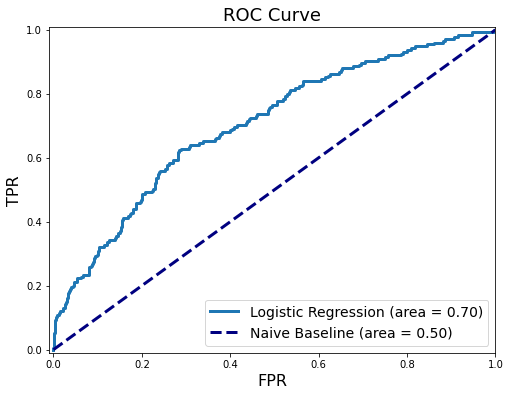

In [16]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

As shown in the plot above, the AUC is approximately 0.70. We want ROC curves that achieve high TPR and low FPR, which corresponds to a higher AUC. One interesting observation from our curve is that our AUC is 0.70, which indicates that our model has a probability of 0.7 of of correctly differentiating between a randomly selected positive observation (person with CHD) and a randomly selected negative observation (person without CHD). Whether this is considered a good probability might be dependent on the stakeholder, but this is interesting because it indicates that our model is relatively leaning towards accurate.

The ROC curve is helpful to decision-makers because it captures the trade-off between the FPR and TPR, which is generally important for considering the accuracy and specificity of our model. A decision-maker studying the medication in question and other medications for CHD might run similar logistic regression models that differ in input variables and compare the ROC curves to determine which model achieves a 'better' trade-off of a high TPR and low FPR, i.e. which model leads to an ROC curve with a higher AUC. Doing so might give decision-makers an idea of which patient combination of variables/characteristics are most important in maximizing this trade-off and improving their own studies/observations on which patients should or shouldn't receive CHD medication.